<a href="https://colab.research.google.com/github/tnewtont/House_Prices_Linear_Regression/blob/main/house_prices_data_wrangling_winsor_top1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import random
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import missingno as msno
import math
import pickle

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import TargetEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from scipy.stats.mstats import winsorize


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

## Important Functions

In [ ]:
# A simple function to quickly load each .csv file
def reader(file_path):
  df = pd.read_csv(file_path)
  return df

In [ ]:
# A function that takes a dataframe and creates another one to help assess with missing values / data preprocessing
def create_missing_vals_df(df):
    # basic missing / unique stats
    percent_missing = df.isnull().sum() * 100 / len(df)
    num_missing     = df.isnull().sum()
    nunique_vals    = df.nunique()

    # compute dominant-value percentage for each column
    dominant_pct = []
    for col in df.columns:
        vc = df[col].value_counts(normalize=True)  # proportions
        if not vc.empty:
            dominant_pct.append(vc.iloc[0] * 100)  # top category’s %
        else:
            dominant_pct.append(0.0)               # all NaNs case

    # assemble into a DataFrame
    missing_vals_df = pd.DataFrame({
        'column_name'     : df.columns,
        'percent_missing' : percent_missing,
        'num_missing'     : num_missing,
        'nunique_vals'    : nunique_vals,
        'dominant_pct'    : dominant_pct
    })
    missing_vals_df.sort_values('percent_missing', ascending=False, inplace=True)
    missing_vals_df.reset_index(drop=True, inplace=True)
    return missing_vals_df

In [ ]:
# To make value_counts() easier
def vc(df, colname, n = None):
  if n == True:
    return df[colname].value_counts(normalize = n)
  else:
    return df[colname].value_counts()

In [ ]:
# To view value_counts() side-by-side, assuming different dataframes and same column
def vc_vc(df1, df2, colname):
  return pd.concat([df1[colname].value_counts(), df2[colname].value_counts()], axis = 1)

In [ ]:
# A function that checks if the unique values in each categorical feature are consistent in both
# training and test datasets.
# col_list is a list of the names of categorical features
def consistent_cat_vals(df1, df2, col_list):
  for col in col_list:
      train_vals = set(df1[col].unique())
      test_vals = set(df2[col].unique())

      missing_in_test = train_vals - test_vals   # values in training but not in test
      missing_in_train = test_vals - train_vals   # values in test but not in training

      if missing_in_test or missing_in_train:
          print(f"Mismatch in {col}:")
          if missing_in_test:
              print(f"  In train but not in test: {missing_in_test}")
          if missing_in_train:
              print(f"  In test but not in train: {missing_in_train}")
      else:
          print(f"{col} matches exactly in train and test.")

# Data Wrangling

## Preparation

In [ ]:
# Load the necessary dataframes
train = reader('/content/train.csv')
test = reader('/content/test.csv')
strong_corr_df = reader('/content/strong_corr_df.csv')
dominance_df = reader('/content/dominance_df.csv')
missing_values = reader('/content/missing_values.csv')
missing_values_train = reader('/content/missing_vals_train.csv')
missing_values_test = reader('/content/missing_vals_test.csv')

In [ ]:
dom_df = dominance_df.copy()

In [ ]:
df1 = train.copy()
df2 = test.copy()

In [ ]:
with open('/content/value_counts_dict.pickle', "rb") as f:
  value_counts_dict = pickle.load(f)

In [ ]:
vcd = value_counts_dict

We will first transform our target variable SalePrice by using Box-Cox and save it for future usage.

In [ ]:
# Save Id for submission and drop it in both dataframes
id_train = df1['Id']
id_test = df2['Id']

df1.drop(columns = 'Id', inplace = True)
df2.drop(columns = 'Id', inplace = True)

We will winsorize our target variable to try to reduce the effect of outliers.

In [ ]:
qs = [0.005, 0.01, 0.02, 0.05, 0.95, 0.98, 0.99, 0.995]
quantiles = train['SalePrice'].quantile(qs)
print(quantiles)

0.005     55000.000
0.010     61815.970
0.020     79000.000
0.050     88000.000
0.950    326100.000
0.980    394931.060
0.990    442567.010
0.995    527331.915
Name: SalePrice, dtype: float64


We will windsorize at the top 1%, leaving the bottom 1% alone.

In [ ]:
upper = df1['SalePrice'].quantile(0.99)
df1['SalePrice_win'] = df1['SalePrice'].clip(upper=upper)

In [ ]:
saleprice_win = df1['SalePrice_win']

We can compare the distribution of SalePrice before and after winsorization.

<Axes: >

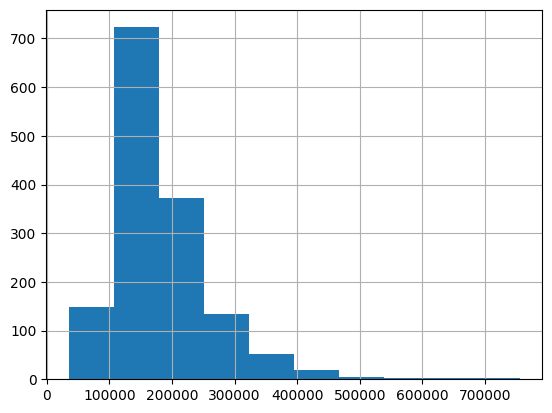

In [ ]:
df1['SalePrice'].hist()

<Axes: >

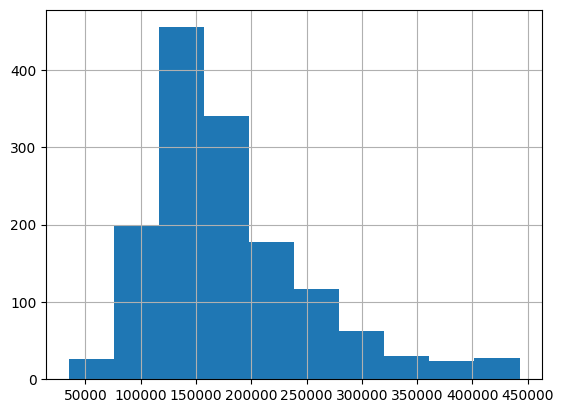

In [ ]:
df1['SalePrice_win'].hist()

In [ ]:
df1.drop(columns = 'SalePrice', inplace = True)

In [ ]:
df1.drop(columns = 'SalePrice_win', inplace = True)

In [ ]:
strong_corr_df

,Feature1,Feature2,Correlation
0,OverallQual,YearBuilt,0.572323
1,OverallQual,YearRemodAdd,0.550684
2,OverallQual,TotalBsmtSF,0.537808
3,OverallQual,GrLivArea,0.593007
4,OverallQual,FullBath,0.550600
5,OverallQual,GarageYrBlt,0.547766
6,OverallQual,GarageCars,0.600671
7,OverallQual,GarageArea,0.562022
8,OverallQual,SalePrice,0.790982
9,YearBuilt,YearRemodAdd,0.592855


In [ ]:
missing_values_train

,column_name,percent_missing,num_missing,nunique_vals
0,PoolQC,99.520548,1453,3
1,MiscFeature,96.301370,1406,4
2,Alley,93.767123,1369,2
3,Fence,80.753425,1179,4
4,MasVnrType,59.726027,872,3
5,FireplaceQu,47.260274,690,5
6,LotFrontage,17.739726,259,110
7,GarageQual,5.547945,81,5
8,GarageFinish,5.547945,81,3
9,GarageType,5.547945,81,6


In [ ]:
missing_values_test

,column_name,percent_missing,num_missing,nunique_vals
0,PoolQC,99.794380,1456,2
1,MiscFeature,96.504455,1408,3
2,Alley,92.666210,1352,2
3,Fence,80.123372,1169,4
4,MasVnrType,61.274846,894,3
5,FireplaceQu,50.034270,730,5
6,LotFrontage,15.558602,227,115
7,GarageYrBlt,5.346127,78,97
8,GarageCond,5.346127,78,5
9,GarageFinish,5.346127,78,3


## Numerical Features

We will take a look at each numerical feature one-by-one and decide how to feature engineer these and do any necesssary imputations.

In [ ]:
num_cols = df1.select_dtypes(include = ['number']).columns.to_list()
num_cols

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

**MSSubClass** uses numerical values to indicate a type of dwelling, so this feature is actually not numerical but rather categorical. Therefore, we will convert the values to strings to keep it more representative.

In [ ]:
df1['MSSubClass'] = df1['MSSubClass'].astype(str)
df2['MSSubClass'] = df2['MSSubClass'].astype(str)

Let's now take a look at **LotFrontage** and **LotArea**.

Here, we will create **LotDepth** which takes the ratio of LotArea to LotFrontage.<br>
We can also create **Frontage_to_Area** which takes the ratio between LotFrontage and LotArea.<br>
Since both features are skewed, we can also create **LogLotFrontage** and **LogLotArea** by applying logarithmic scaling.

In [ ]:
df1['LotDepth'] = df1['LotArea'] / df1['LotFrontage']
df2['LotDepth'] = df2['LotArea'] / df2['LotFrontage']

df1['Frontage_Area_Ratio'] = df1['LotFrontage'] / df1['LotArea']
df2['Frontage_Area_Ratio'] = df2['LotFrontage'] / df2['LotArea']

df1['LogLotArea'] = np.log1p(df1['LotArea'])
df1['LogLotFrontage'] = np.log1p(df1['LotFrontage'])

df2['LogLotArea'] = np.log1p(df2['LotArea'])
df2['LogLotFrontage'] = np.log1p(df2['LotFrontage'])

The values of **OverallQual** and **OverallCond**, which range from 0 to 10, suggest that both features are ordinal. Therefore, we will leave them as is.

We will now take the difference of **YrSold** and **YearBuilt** to create **HouseAge**, which indicates the age of the house.

In [ ]:
df1['HouseAge'] = df1['YrSold'] - df1['YearBuilt']
df2['HouseAge'] = df2['YrSold'] - df2['YearBuilt']

For **YearRemodAdd**, we will convert this to a boolean feature called **Remodeled** where 0 indicates no remodeling was done and 1 indicates otherwise.

In [ ]:
df1['Remodeled'] = (df1['YearBuilt'] != df1['YearRemodAdd']).astype(int)
df2['Remodeled'] = (df2['YearBuilt'] != df2['YearRemodAdd']).astype(int)

Let's now take a look at **MasVnrArea**. Note that a value of 0 indicates no masonry veneer present. Since there are 8 and 15 missing values in the training and test datasets respectively, for simplicity we will impute with 0.<br>
We will also create a binary feature called **HasMasVnr** to indicate a presence of masonry veneer.<br>
Since this feature is also right-skewed, we will also apply logarithmic scaling to create **LogMasVnrArea**.<br>
We might also be interested in seeing whether or not this feature is proportional to the house's living area, so we can create **VeneerAreaRatio** by taking **MasVnrArea** and dividing it by **GrLivArea**.

In [ ]:
df1['MasVnrArea'] = df1['MasVnrArea'].fillna(0)
df2['MasVnrArea'] = df2['MasVnrArea'].fillna(0)

df1['HasMasVnr'] = (df1['MasVnrArea'] > 0).astype(int)
df2['HasMasVnr'] = (df2['MasVnrArea'] > 0).astype(int)

df1['LogMasVnrArea'] = np.log1p(df1['MasVnrArea'])
df2['LogMasVnrArea'] = np.log1p(df2['MasVnrArea'])

df1['VeneerAreaRatio'] = df1['MasVnrArea'] / df1['GrLivArea']
df2['VeneerAreaRatio'] = df2['MasVnrArea'] / df2['GrLivArea']

For **BsmtFinSF1** and **BsmtFinSF2**, the document that gives feature descriptions isn't as informative or descriptive, so my guess is that the former refers to the square footage of the primary finished basement and the latter refers to the secondary finished basement. We can infer that a value of 0 indicates the basement is unfinished. We can then impute any missing values with 0.<br>
We can also first try creating a feature called **TotalBsmtFinSF** by summing those two. <br>
Afterwards, for **BsmtUnfSF**, we will impute with zero.<br>
We can also look at the finished and unfinished ratios by creating **FinishedBsmtRatio** and **UnfinishedBsmtRatio**, respectively.

In [ ]:
df1['BsmtFinSF1'] = df1['BsmtFinSF1'].fillna(0)
df1['BsmtFinSF2'] = df1['BsmtFinSF2'].fillna(0)
df2['BsmtFinSF1'] = df2['BsmtFinSF1'].fillna(0)
df2['BsmtFinSF2'] = df2['BsmtFinSF2'].fillna(0)

df1['TotalBsmtFinSF'] = df1['BsmtFinSF1'] + df1['BsmtFinSF2']
df2['TotalBsmtFinSF'] = df2['BsmtFinSF1'] + df2['BsmtFinSF2']

In [ ]:
df1['TotalBsmtSF'] = df1['TotalBsmtSF'].fillna(0)
df2['TotalBsmtSF'] = df2['TotalBsmtSF'].fillna(0)

In [ ]:
df1['BsmtUnfSF'] = df1['BsmtUnfSF'].fillna(0)
df2['BsmtUnfSF'] = df2['BsmtUnfSF'].fillna(0)

df1['FinishedBsmtRatio'] = df1['TotalBsmtFinSF'] / df1['TotalBsmtSF'].replace(0, np.nan)
df2['FinishedBsmtRatio'] = df2['TotalBsmtFinSF'] / df2['TotalBsmtSF'].replace(0, np.nan)

df1['UnfinishedBsmtRatio'] = df1['BsmtUnfSF'] / df1['TotalBsmtSF'].replace(0, np.nan)
df2['UnfinishedBsmtRatio'] = df2['BsmtUnfSF'] / df2['TotalBsmtSF'].replace(0, np.nan)

In [ ]:
# Checking if the sum calculated is consistent with TotalBsmtSF, which it is
CalculatedTotalBsmtSF1 = df1['BsmtFinSF1'].fillna(0) + df1['BsmtFinSF2'].fillna(0) + df1['BsmtUnfSF'].fillna(0)
(CalculatedTotalBsmtSF1 == df1['TotalBsmtSF']).sum()

np.int64(1460)

In [ ]:
CalculatedTotalBsmtSF2 = df2['BsmtFinSF1'].fillna(0) + df2['BsmtFinSF2'].fillna(0) + df2['BsmtUnfSF'].fillna(0)
(CalculatedTotalBsmtSF2 == df2['TotalBsmtSF']).sum()

np.int64(1459)

Now we will take a closer look at **1stFlrSF** and **2ndFlrSF**. There are some rows that take on zero values for **2ndFlrSF**, which means the house has one story. We can create a new feature called **Has2ndFlr** which is a boolean based on the condition of whether or not **2ndFlrSF** is greater than 0.<br>

We can also create **TotalFlrSF** by summing the two to capture total living space.<br>
Perhaps we could also check how proportional the second floor is to the total floor footage by defining **Prop2ndFlr** as **2ndFlrSF** divided by **TotalFlrSF**.<br>
We can then take this a step further and take the proportion of the two floors by defining **FlrRatio** as **2ndFlrSF** divided by **1stFlrSF**.

In [ ]:
df1['Has2ndFlr'] = (df1['2ndFlrSF'] > 0).astype(int)
df2['Has2ndFlr'] = (df2['2ndFlrSF'] > 0).astype(int)

df1['TotalFlrSF'] = df1['1stFlrSF'] + df1['2ndFlrSF']
df2['TotalFlrSF'] = df2['1stFlrSF'] + df2['2ndFlrSF']

df1['Prop2ndFlr'] = df1['2ndFlrSF'] / df1['TotalFlrSF']
df2['Prop2ndFlr'] = df2['2ndFlrSF'] / df2['TotalFlrSF']

df1['FlrRatio'] = df1['2ndFlrSF'] / df1['1stFlrSF']
df2['FlrRatio'] = df2['2ndFlrSF'] / df2['1stFlrSF']

Based on what we can infer from **LowQualFinSF**, we can create a feature called **LowQualFinRatio** which takes this divided by **GrLivArea**, which can help capture the total proportion of the house has low quality finish. In addition, we can create a binary feature called **HasLowQualFin** to indicate the presence of low quality finish.<br>
We could also see how this feature can interact with **OverallQual** by multiplying the two to capture the extent of the low quality finish; we will call this feature **OverallQual_LowQual_Interact**.

In [ ]:
df1['HasLowQualFin'] = (df1['LowQualFinSF'] > 0).astype(int)
df2['HasLowQualFin'] = (df2['LowQualFinSF'] > 0).astype(int)

df1['OverallQual_LowQual_Interact'] = df1['LowQualFinSF'] * df1['OverallQual']
df2['OverallQual_LowQual_Interact'] = df2['LowQualFinSF'] * df2['OverallQual']

Now let's investigate **GrLivArea**.<br>
Since it's right-skewed, we can apply a logarithmic transformation to create **LogGrLivArea**.<br>
More importantly, since this feature has relatively strong predictive power, we can multiply it with **OverallQual** to create **GrLivArea_OverallQual_Interact**.
We can also try binning to see how certain thresholds can affect our model via **GrLivAreaBin**.

In [ ]:
df1['LogGrLivArea'] = np.log1p(df1['GrLivArea'])
df2['LogGrLivArea'] = np.log1p(df2['GrLivArea'])

df1['Qual_GrLivArea'] = df1['GrLivArea'] * df1['OverallQual']
df2['Qual_GrLivArea'] = df2['GrLivArea'] * df2['OverallQual']

In [ ]:
df1['GrLivAreaBin'] = pd.qcut(df1['GrLivArea'], q=4, labels=False)
df2['GrLivAreaBin'] = pd.qcut(df2['GrLivArea'], q=4, labels=False)

In [ ]:
# Checking for outliers. We won't remove these rows, but we'll keep them in mind.
upper_bound = df1['GrLivArea'].quantile(0.99)
outliers = df1[df1['GrLivArea'] > upper_bound]
outliers

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,UnfinishedBsmtRatio,Has2ndFlr,TotalFlrSF,Prop2ndFlr,FlrRatio,HasLowQualFin,OverallQual_LowQual_Interact,LogGrLivArea,Qual_GrLivArea,GrLivAreaBin
118,60,RL,90.0,12376,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0.121339,1,3222,0.472688,0.896410,0,0,8.078068,22554,3
185,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,...,1.000000,1,3036,0.500000,1.000000,1,5720,8.191186,36080,3
304,75,RM,87.0,18386,Pave,NaN,Reg,Lvl,AllPub,Inside,...,1.000000,1,3493,0.520470,1.085373,0,0,8.158802,24451,3
496,20,RL,NaN,12692,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.615313,0,3228,0.000000,0.000000,0,0,8.079928,25824,3
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0.279796,1,4676,0.328914,0.490121,0,0,8.450412,46760,3
608,70,RL,78.0,12168,Pave,NaN,Reg,HLS,AllPub,Inside,...,0.556477,1,3194,0.392611,0.646392,0,0,8.069342,25552,3
635,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,Inside,...,0.822222,1,2880,0.500000,1.000000,1,3090,8.130354,20370,3
691,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.404664,1,4316,0.433735,0.765957,0,0,8.370316,43160,3
769,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,CulDSac,...,0.141818,1,3279,0.484599,0.940237,0,0,8.095599,26232,3
798,60,RL,104.0,13518,Pave,NaN,Reg,Lvl,AllPub,Inside,...,1.000000,1,3140,0.373885,0.597152,0,0,8.052296,28260,3


Let's take a look at **BsmtFullBath** and **BsmtHalfBath**. We can create **TotalBsmtBath** that captures the total number of bathrooms and give less importance to half baths, so we'll multiply by 0.5.

In [ ]:
print(df1['BsmtHalfBath'].isna().sum())
print(df2['BsmtHalfBath'].isna().sum())
print(df1['BsmtFullBath'].isna().sum())
print(df2['BsmtFullBath'].isna().sum())

0
2
0
2


In [ ]:
df2['BsmtHalfBath'] = df2['BsmtHalfBath'].fillna(0)
df2['BsmtFullBath'] = df2['BsmtFullBath'].fillna(0)

In [ ]:
df1['TotalBsmtBath'] = df1['BsmtFullBath'] + 0.5 * df1['BsmtHalfBath']
df2['TotalBsmtBath'] = df2['BsmtFullBath'] + 0.5 * df2['BsmtHalfBath']

Now we will look at the total number of rooms above ground, **BedroomAbvGr**. We should take special note of a house in the training dataset that has 8 rooms, and some houses in both the training and test datasets have 0 bedrooms.

In [ ]:
vc_vc(df1, df2, 'BedroomAbvGr')

,count,count
BedroomAbvGr,,
3,804,792.0
2,358,384.0
4,213,187.0
1,50,53.0
5,21,27.0
6,7,14.0
0,6,2.0
8,1,NaN


In [ ]:
df1.loc[df1['BedroomAbvGr'] == 8] # This house is a 2 Family Conversion.

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Has2ndFlr,TotalFlrSF,Prop2ndFlr,FlrRatio,HasLowQualFin,OverallQual_LowQual_Interact,LogGrLivArea,Qual_GrLivArea,GrLivAreaBin,TotalBsmtBath
635,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,Inside,...,1,2880,0.5,1.0,1,3090,8.130354,20370,3,0.0


In [ ]:
df1.loc[df1['BedroomAbvGr'] == 0]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Has2ndFlr,TotalFlrSF,Prop2ndFlr,FlrRatio,HasLowQualFin,OverallQual_LowQual_Interact,LogGrLivArea,Qual_GrLivArea,GrLivAreaBin,TotalBsmtBath
53,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,Inside,...,0,1842,0.000000,0.000000,0,0,7.519150,16578,3,2.0
189,120,RL,41.0,4923,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,1593,0.000000,0.000000,0,0,7.374002,12744,2,1.0
634,90,RL,64.0,6979,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,1056,0.000000,0.000000,0,0,6.963190,6336,0,2.0
1163,90,RL,60.0,12900,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,1258,0.000000,0.000000,0,0,7.138073,5032,1,2.0
1213,80,RL,NaN,10246,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,960,0.000000,0.000000,0,0,6.867974,3840,0,1.5
1270,40,RL,NaN,23595,Pave,NaN,Reg,Low,AllPub,Inside,...,1,1524,0.125984,0.144144,0,0,7.329750,10668,2,2.0


In [ ]:
# We will cap the observation to 6.
df1['BedroomAbvGr'] = df1['BedroomAbvGr'].clip(upper=6)

In [ ]:
# Checking that the observation is removed properly via value counts
vc(df1, 'BedroomAbvGr')

,count
BedroomAbvGr,
3,804
2,358
4,213
1,50
5,21
6,8
0,6


In [ ]:
df1

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Has2ndFlr,TotalFlrSF,Prop2ndFlr,FlrRatio,HasLowQualFin,OverallQual_LowQual_Interact,LogGrLivArea,Qual_GrLivArea,GrLivAreaBin,TotalBsmtBath
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,1,1710,0.499415,0.997664,0,0,7.444833,11970,2,1.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,1262,0.000000,0.000000,0,0,7.141245,7572,1,0.5
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,1,1786,0.484882,0.941304,0,0,7.488294,12502,3,1.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,1,1717,0.440303,0.786681,0,0,7.448916,12019,2,1.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,1,2198,0.479072,0.919651,0,0,7.695758,17584,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,1,1647,0.421372,0.728227,0,0,7.407318,9882,2,0.0
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,2073,0.000000,0.000000,0,0,7.637234,12438,3,1.0
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,1,2340,0.492308,0.969697,0,0,7.758333,16380,3,0.0
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,1078,0.000000,0.000000,0,0,6.983790,5390,0,1.0


For **KitchenAbvGr**, we should check for unusual observations.

In [ ]:
vc(df1, 'KitchenAbvGr') # Two houses have 3 kitchens and one house has none.

,count
KitchenAbvGr,
1,1392
2,65
3,2
0,1


In [ ]:
vc(df2, 'KitchenAbvGr') # Two houses have no kitchens

,count
KitchenAbvGr,
1,1393
2,64
0,2


In [ ]:
df1.loc[df1['KitchenAbvGr'] == 0]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Has2ndFlr,TotalFlrSF,Prop2ndFlr,FlrRatio,HasLowQualFin,OverallQual_LowQual_Interact,LogGrLivArea,Qual_GrLivArea,GrLivAreaBin,TotalBsmtBath
954,90,RL,35.0,9400,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,980,0.0,0.0,0,0,6.888572,5880,0,1.0


In [ ]:
# We'll "impute" the observations to 1.
df1.loc[df1['KitchenAbvGr'] == 0, 'KitchenAbvGr'] = 1
df2.loc[df2['KitchenAbvGr'] == 0, 'KitchenAbvGr'] = 1

Similarly, let's check the distribution of **TotRmsAbvGrd**.

In [ ]:
vc(df1, 'TotRmsAbvGrd').sort_index()

,count
TotRmsAbvGrd,
2,1
3,17
4,97
5,275
6,402
7,329
8,187
9,75
10,47


In [ ]:
vc(df2, 'TotRmsAbvGrd').sort_index()

,count
TotRmsAbvGrd,
3,8
4,99
5,308
6,442
7,320
8,160
9,68
10,33
11,14


In this case, we'll just leave the values as is.

Now let's investigate **Fireplaces**.

In [ ]:
vc(df1, 'Fireplaces').sort_index()

,count
Fireplaces,
0,690
1,650
2,115
3,5


In [ ]:
vc(df2, 'Fireplaces').sort_index()

,count
Fireplaces,
0,730
1,618
2,104
3,6
4,1


We'll convert this feature into a boolean.

In [ ]:
df1['Fireplaces'] = (df1['Fireplaces'] > 0).astype(int)
df2['Fireplaces'] = (df2['Fireplaces'] > 0).astype(int)

We should now take a closer look at the features related to the garage, namely the following:<br>


*   **GarageType**
*   **GarageYrBlt**
*   **GarageFinish**
*   **GarageCars**
*   **GarageArea**
*   **GarageQual**
*   **GarageCond**

More specifically, we need to take into consideration of which observations have no garage at all.

In [ ]:
df2['GarageYrBlt'].isna().sum() # 78 rows contain nulls. Let's investigate those rows

np.int64(78)

In [ ]:
GarageYrBlt_where_null = np.where(df2['GarageYrBlt'].isnull() == True)

In [ ]:
df2.loc[GarageYrBlt_where_null][['GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'GarageType', 'GarageFinish']]

,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,GarageType,GarageFinish
53,NaN,0.0,0.0,NaN,NaN,NaN,NaN
71,NaN,0.0,0.0,NaN,NaN,NaN,NaN
79,NaN,0.0,0.0,NaN,NaN,NaN,NaN
92,NaN,0.0,0.0,NaN,NaN,NaN,NaN
96,NaN,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1433,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1449,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1453,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1454,NaN,0.0,0.0,NaN,NaN,NaN,NaN


Here, **GarageYrBlt**, **GarageCars** and **GarageArea** are the three numerical features related to the garage, with the remaining being categorical. For the categorical features, we will impute by replacing the nulls with 'None'. Since **GarageCars** and **GarageArea** being 0 indicate no garage, it makes sense to impute the corresponding rows with 0. Furthermore, we will instead construct a boolean feature called **HasGarage** to indicate the presence of a garage.

In [ ]:
num_garage_cols = ['GarageCars', 'GarageArea']
df1[num_garage_cols] = df1[num_garage_cols].fillna(0)
df2[num_garage_cols] = df2[num_garage_cols].fillna(0)

df1['HasGarage'] = df1['GarageType'].notnull().astype(int)
df2['HasGarage'] = df2['GarageType'].notnull().astype(int)

cat_garage_cols = ['GarageQual', 'GarageCond', 'GarageType', 'GarageFinish']
df1[cat_garage_cols] = df1[cat_garage_cols].fillna('None')
df2[cat_garage_cols] = df2[cat_garage_cols].fillna('None')

We now proceed with **WoodDeckSF**.

In [ ]:
vc(df1, 'WoodDeckSF').sort_index()

,count
WoodDeckSF,
0,761
12,2
24,2
26,2
28,2
...,...
668,1
670,1
728,1


In [ ]:
vc(df2, 'WoodDeckSF').sort_index()

,count
WoodDeckSF,
0,762
4,1
14,1
16,1
20,1
...,...
657,1
684,1
690,1


A value of 0 indicates the absence of a wooden deck. This feature is also right-skewed, so we can apply a logarithmic transformation and create **LogWoodDeckSF**. We can also create a boolean **HasWoodDeck** to indicate the presence.

In [ ]:
df1['LogWoodDeckSF'] = np.log1p(df1['WoodDeckSF'])
df2['LogWoodDeckSF'] = np.log1p(df2['WoodDeckSF'])

In [ ]:
df1['HasWoodDeck'] = (df1['WoodDeckSF'] > 0).astype(int)
df2['HasWoodDeck'] = (df2['WoodDeckSF'] > 0).astype(int)

Let's now take a look at the features related to the porch:

* **OpenPorchSF**
* **EnclosedPorch**
* **3SsnPorch**
* **ScreenPorch**



In [ ]:
porch_cols = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

In [ ]:
df1[porch_cols]

,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
0,61,0,0,0
1,0,0,0,0
2,42,0,0,0
3,35,272,0,0
4,84,0,0,0
...,...,...,...,...
1455,40,0,0,0
1456,0,0,0,0
1457,60,0,0,0
1458,0,112,0,0


In [ ]:
df2[porch_cols]

,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
0,0,0,0,120
1,36,0,0,0
2,34,0,0,0
3,36,0,0,0
4,82,0,0,144
...,...,...,...,...
1454,0,0,0,0
1455,24,0,0,0
1456,0,0,0,0
1457,32,0,0,0


Each of these porch-related features are heavily skewed, so we shall apply a logarithmic transformation. We can also add the four columns together to create **TotalPorchSF** to capture total outdoor square footage. We can also create a boolean feature for each of them.

In [ ]:
for col in porch_cols:
    df1[col + '_log'] = np.log1p(df1[col])
    df2[col + '_log'] = np.log1p(df2[col])

In [ ]:
df1['TotalPorchSF'] = df1['OpenPorchSF'] + df1['EnclosedPorch'] + df1['3SsnPorch'] + df1['ScreenPorch']
df2['TotalPorchSF'] = df2['OpenPorchSF'] + df2['EnclosedPorch'] + df2['3SsnPorch'] + df2['ScreenPorch']

In [ ]:
# Apply logarithmic transformation to the sum
df1['TotalPorchSF_log'] = np.log1p(df1['TotalPorchSF'])
df2['TotalPorchSF_log'] = np.log1p(df2['TotalPorchSF'])

In [ ]:
for col in porch_cols:
    df1['Has_' + col] = (df1[col] > 0).astype(int)
    df2['Has_' + col] = (df2[col] > 0).astype(int)

Let's now take a look at **PoolArea**.

In [ ]:
vc(df1, 'PoolArea').sort_index()

,count
PoolArea,
0,1453
480,1
512,1
519,1
555,1
576,1
648,1
738,1


In [ ]:
vc(df2, 'PoolArea').sort_index()

,count
PoolArea,
0,1453
144,1
228,1
368,1
444,1
561,1
800,1


Even though the vast majority of the observations in both datasets have no pool at all, we can convert this feature into a boolean-valued feature called **HasPool** to capture some information that might be useful to our model.

In [ ]:
df1['PoolArea'] = (df1['PoolArea'] > 0).astype(int)
df2['PoolArea'] = (df2['PoolArea'] > 0).astype(int)

df1 = df1.rename(columns = {'PoolArea': 'HasPool'})
df2 = df2.rename(columns = {'PoolArea': 'HasPool'})

For **MiscVal**, we'll drop it altogether.

In [ ]:
df1.drop(columns = 'MiscVal', inplace = True)
df2.drop(columns = 'MiscVal', inplace = True)

Lastly, we will now look at the two time-related features **MoSold** and **YrSold**.

In [ ]:
df1[['MoSold', 'YrSold']]

,MoSold,YrSold
0,2,2008
1,5,2007
2,9,2008
3,2,2006
4,12,2008
...,...,...
1455,8,2007
1456,2,2010
1457,5,2010
1458,4,2010


In [ ]:
df2[['MoSold', 'YrSold']]

,MoSold,YrSold
0,6,2010
1,6,2010
2,3,2010
3,6,2010
4,1,2010
...,...,...
1454,6,2006
1455,4,2006
1456,9,2006
1457,7,2006


Since months are cyclical and revolve around 12, we can apply sine and cosine transformations (i.e. cyclical encoding). We'll leave **YrSold** as is.

In [ ]:
df1['MoSold_sin'] = np.sin(2 * np.pi * df1['MoSold'] / 12)
df1['MoSold_cos'] = np.cos(2 * np.pi * df1['MoSold'] / 12)

df2['MoSold_sin'] = np.sin(2 * np.pi * df2['MoSold'] / 12)
df2['MoSold_cos'] = np.cos(2 * np.pi * df2['MoSold'] / 12)

Let's review the dataframe that contains pairs of features with considerable to high correlation and feature engineer them by performing pairwise multiplication. In addition, since SalePrice is our target, we will filter the dataframe to exclude that.

In [ ]:
f1f2 = strong_corr_df.loc[(strong_corr_df['Feature1'] != 'SalePrice') &
 (strong_corr_df['Feature2'] != 'SalePrice')
  & ((strong_corr_df['Feature1'] != strong_corr_df['Feature2']))].sort_values(by = 'Correlation', ascending = False)
f1f2

,Feature1,Feature2,Correlation
35,GarageCars,GarageArea,0.882475
10,YearBuilt,GarageYrBlt,0.825667
27,GrLivArea,TotRmsAbvGrd,0.825489
17,TotalBsmtSF,1stFlrSF,0.819530
21,2ndFlrSF,GrLivArea,0.687501
31,BedroomAbvGr,TotRmsAbvGrd,0.676620
16,BsmtFinSF1,BsmtFullBath,0.649212
13,YearRemodAdd,GarageYrBlt,0.642277
25,GrLivArea,FullBath,0.630012
24,2ndFlrSF,TotRmsAbvGrd,0.616423


In [ ]:
for index, row in f1f2.iterrows():
    feat1 = row['Feature1']
    feat2 = row['Feature2']
    # Create a new column name by concatenating the feature names
    new_col_name = f"{feat1}_x_{feat2}"

    # Multiply the features and assign the result to the new column in both datasets
    df1[new_col_name] = df1[feat1] * df1[feat2]
    df2[new_col_name] = df2[feat1] * df2[feat2]

We are now done with feature engineering with the numerical features. Let's now robust scale them and apply KNN imputation.

We now proceed with robust scaling and KNN Imputation on the numerical features.

In [ ]:
num_cols = df1.select_dtypes(include = ['number']).columns.to_list()

In [ ]:
# Build the pipeline
pipeline = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('imputer', KNNImputer(n_neighbors=5))
])

# Fit the pipeline on the training data
pipeline.fit(df1[num_cols])

# Transform the training data
df1_imputed_scaled = pipeline.transform(df1[num_cols])

# Transform the test data using the same fitted pipeline
df2_imputed_scaled = pipeline.transform(df2[num_cols])

In [ ]:
df1[num_cols] = df1_imputed_scaled
df2[num_cols] = df2_imputed_scaled

In [ ]:
# Double checking if any nulls remain in the numerical features
print(df1[num_cols].isna().sum().sum())
print(df2[num_cols].isna().sum().sum())

0
0


## Categorical Features

### Preparation

In [ ]:
df1_cat = df1.select_dtypes(exclude = ['number'])
df2_cat = df2.select_dtypes(exclude = ['number'])

In [ ]:
cat_cols = df1.select_dtypes(exclude = ['number']).columns.to_list()
cat_cols

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [ ]:
MV_train_cat = create_missing_vals_df(df1_cat)
MV_train_cat.query('percent_missing > 0')

,column_name,percent_missing,num_missing,nunique_vals,dominant_pct
0,PoolQC,99.520548,1453,3,42.857143
1,MiscFeature,96.301370,1406,4,90.740741
2,Alley,93.767123,1369,2,54.945055
3,Fence,80.753425,1179,4,55.871886
4,MasVnrType,59.726027,872,3,75.680272
5,FireplaceQu,47.260274,690,5,49.350649
6,BsmtFinType2,2.602740,38,6,88.326301
7,BsmtExposure,2.602740,38,4,67.018284
8,BsmtCond,2.534247,37,4,92.129304
9,BsmtQual,2.534247,37,4,45.607871


In [ ]:
MV_test_cat = create_missing_vals_df(df2_cat)
MV_test_cat.query('percent_missing > 0')

,column_name,percent_missing,num_missing,nunique_vals,dominant_pct
0,PoolQC,99.794380,1456,2,66.666667
1,MiscFeature,96.504455,1408,3,90.196078
2,Alley,92.666210,1352,2,65.420561
3,Fence,80.123372,1169,4,59.310345
4,MasVnrType,61.274846,894,3,76.814159
5,FireplaceQu,50.034270,730,5,49.931413
6,BsmtCond,3.084304,45,4,91.584158
7,BsmtQual,3.015764,44,4,44.805654
8,BsmtExposure,3.015764,44,4,67.208481
9,BsmtFinType1,2.878684,42,6,30.416373


We'll merge both dataframes side-by-side to better assist with preprocessing.

In [ ]:
MV_cat_merged = MV_train_cat.merge(MV_test_cat, on='column_name', how='outer', suffixes=('_train', '_test'))
MV_cat_merged.sort_values(by = ['percent_missing_train', 'percent_missing_test'], ascending = False)


,column_name,percent_missing_train,num_missing_train,nunique_vals_train,dominant_pct_train,percent_missing_test,num_missing_test,nunique_vals_test,dominant_pct_test
37,PoolQC,99.520548,1453,3,42.857143,99.794380,1456,2,66.666667
34,MiscFeature,96.301370,1406,4,90.740741,96.504455,1408,3,90.196078
0,Alley,93.767123,1369,2,54.945055,92.666210,1352,2,65.420561
15,Fence,80.753425,1179,4,55.871886,80.123372,1169,4,59.310345
33,MasVnrType,59.726027,872,3,75.680272,61.274846,894,3,76.814159
16,FireplaceQu,47.260274,690,5,49.350649,50.034270,730,5,49.931413
3,BsmtExposure,2.602740,38,4,67.018284,3.015764,44,4,67.208481
5,BsmtFinType2,2.602740,38,6,88.326301,2.878684,42,6,87.297107
2,BsmtCond,2.534247,37,4,92.129304,3.084304,45,4,91.584158
6,BsmtQual,2.534247,37,4,45.607871,3.015764,44,4,44.805654


In [ ]:
MV_cat_merged.sort_values(by = ['dominant_pct_train', 'dominant_pct_test'], ascending = False)

,column_name,percent_missing_train,num_missing_train,nunique_vals_train,dominant_pct_train,percent_missing_test,num_missing_test,nunique_vals_test,dominant_pct_test
43,Utilities,0.000000,0,2,99.931507,0.137080,2,1,100.000000
42,Street,0.000000,0,2,99.589041,0.000000,0,2,99.588759
9,Condition2,0.000000,0,8,98.972603,0.000000,0,5,98.971899
38,RoofMatl,0.000000,0,8,98.219178,0.000000,0,4,98.834818
23,Heating,0.000000,0,6,97.808219,0.000000,0,4,99.108979
28,LandSlope,0.000000,0,3,94.657534,0.000000,0,3,95.681974
7,CentralAir,0.000000,0,2,93.493151,0.000000,0,2,93.077450
18,Functional,0.000000,0,7,93.150685,0.137080,2,7,93.136582
2,BsmtCond,2.534247,37,4,92.129304,3.084304,45,4,91.584158
36,PavedDrive,0.000000,0,3,91.780822,0.000000,0,3,89.170665


We are going to utilize the following strategies for preprocessing the categorical features and place them into subsets:
1.  Condense some values within a categorical feature into a single value for better data alignment.
2. One hot encode.
3. Convert the feature into binary/boolean-valued.
4. Apply ordinal encoding if the feature shows natural ordering.
5. Drop categorical features altogether if they are redundant or don't add any value to our model.<br>
(I will be checking the value_counts() for each categorical feature, but to avoid redundancy throughout the notebook, I won't show them here.)

In [ ]:
# Save the above dataframe for future usage
MV_cat_merged.to_csv('MV_cat_merged.csv', index = False)

In [ ]:
# basements = df1.loc[df1['BsmtExposure'].isna()][['TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2',
#                                     'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinType1',
#                                     'BsmtCond', 'BsmtQual']]
# basements

In [ ]:
# basements2 = df2.loc[df2['BsmtExposure'].isna()][['TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2',
#                                     'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinType1',
#                                     'BsmtCond', 'BsmtQual']]
# basements2

### Sorting Each Categorical Column By Type of Encoding and Preliminary Imputation

In [ ]:
cat_grouping = ['Condition1', 'SaleType', 'Foundation'] # These will eventually get one-hot encoded

In [ ]:
cat_one_hot = ['BsmtFinType1', 'BsmtFinType2', 'BldgType', 'SaleCondition', 'MSZoning',
               'LotConfig', 'GarageType', 'HouseStyle', 'GarageFinish', 'Neighborhood',
               'Exterior1st', 'Exterior2nd', 'MSSubClass']

In [ ]:
cat_boolean = ['CentralAir']

In [ ]:
cat_ordinal = ['Electrical','Functional', 'ExterCond', 'BsmtCond',
               'BsmtExposure', 'LotShape',
               'ExterQual', 'HeatingQC', 'KitchenQual']

In [ ]:
cat_cols_drop = ['PoolQC', 'MiscFeature', 'Alley', 'PavedDrive', 'Utilities', 'Street', 'Condition2', 'RoofMatl',
                 'Heating', 'LandSlope', 'GarageCond', 'LandContour', 'GarageQual', 'RoofStyle', 'MasVnrType',
                 'Fence', 'FireplaceQu', 'BsmtQual']

In [ ]:
cat_types = [cat_grouping, cat_one_hot, cat_boolean, cat_ordinal, cat_cols_drop]

In this particular case, a row in the training dataset and two rows in the test dataset have inconsistent values with **BsmtExposure**, so we need to do extra preprocessing to make the necessary imputation. Since the majority of houses with unfinished basements have no basement exposure, we impute those rows with No.

In [ ]:
df1.loc[df1['BsmtFinType2'] == 'Unf']['BsmtExposure'].value_counts()

,count
BsmtExposure,
No,850
Av,196
Gd,113
Mn,96


In [ ]:
df2.loc[df2['BsmtFinType2'] == 'Unf']['BsmtExposure'].value_counts()

,count
BsmtExposure,
No,847
Av,166
Gd,120
Mn,102


In [ ]:
df2.loc[df2['Exterior1st'].isna() & df2['Exterior2nd'].isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,OverallQual_x_GarageArea,FullBath_x_TotRmsAbvGrd,OverallQual_x_YearRemodAdd,OverallQual_x_FullBath,OverallQual_x_GarageYrBlt,YearBuilt_x_GarageCars,OverallQual_x_TotalBsmtSF,BsmtFinSF1_x_TotalBsmtSF,GrLivArea_x_BedroomAbvGr,2ndFlrSF_x_BedroomAbvGr
691,30,RL,0.761905,2.488019,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-1.32846,-0.625,-0.449167,-0.555556,-0.494893,-1.931406,0.5218,1.703786,-0.396996,0.0


In [ ]:
mask_train = (df1['BsmtFinType2'] == 'Unf') & (df1['BsmtExposure'].isnull())
df1.loc[mask_train, 'BsmtExposure'] = 'No'

In [ ]:
mask_test = (df2['BsmtFinType2'] == 'Unf') & (df2['BsmtExposure'].isnull())
df2.loc[mask_test, 'BsmtExposure'] = 'No'

In [ ]:
# Double checking imputation is done successfully
df1.loc[948]['BsmtExposure']

'No'

In [ ]:
df2.iloc[[27, 888]]['BsmtExposure']

,BsmtExposure
27,No
888,No


In [ ]:
df1['Neighborhood'].value_counts()

,count
Neighborhood,
NAmes,225
CollgCr,150
OldTown,113
Edwards,100
Somerst,86
Gilbert,79
NridgHt,77
Sawyer,74
NWAmes,73


In [ ]:
df2['Neighborhood'].value_counts()

,count
Neighborhood,
NAmes,218
OldTown,126
CollgCr,117
Somerst,96
Edwards,94
NridgHt,89
Gilbert,86
Sawyer,77
SawyerW,66


Here, we are going to double check if we have reviewed every single categorical column and that it's consistent with the original datasets.

In [ ]:
categorical_cols = MV_cat_merged['column_name'].to_list()

In [ ]:
categorical_cols2 = list(itertools.chain(cat_grouping, cat_one_hot, cat_boolean, cat_ordinal, cat_cols_drop))

In [ ]:
set_cat = set(categorical_cols)   # Original categorical columns
set_cat2 = set(categorical_cols2) # Subset lists combined

# Columns in categorical_cols but not in categorical_cols2
missing_in_cat2 = set_cat - set_cat2
print("Missing in cat2:", missing_in_cat2)

# Columns in categorical_cols2 but not in categorical_cols (just in case)
extra_in_cat2 = set_cat2 - set_cat
print("Extra in cat2:", extra_in_cat2)

Missing in cat2: set()
Extra in cat2: set()


In [ ]:
# Some imputations
df2['SaleType'] = df2['SaleType'].fillna('WD')
df2['MSZoning'] = df2['MSZoning'].fillna('RL')

df1['BsmtExposure'] = df1['BsmtExposure'].fillna('No')
df2['BsmtExposure'] = df2['BsmtExposure'].fillna('No')

df1['KitchenQual'] = df1['KitchenQual'].fillna('TA')
df2['KitchenQual'] = df2['KitchenQual'].fillna('TA')

df2['Exterior1st'] = df2['Exterior1st'].fillna('Unknown')
df2['Exterior2nd'] = df2['Exterior2nd'].fillna('Unknown')

We will make a copy of the training and test datasets that we have preprocessed thus far.

### More Imputation

In [ ]:
df3 = df1.copy()
df4 = df2.copy()

We will first drop the columns listed in **cat_cols_drop**.

In [ ]:
df3 = df3.drop(columns = cat_cols_drop)
df4 = df4.drop(columns = cat_cols_drop)

We will now do any remaining imputations. Let's check the training dataset first.

In [ ]:
df3.loc[:, df3.isna().any()]

,BsmtCond,BsmtFinType1,BsmtFinType2,Electrical
0,TA,GLQ,Unf,SBrkr
1,TA,ALQ,Unf,SBrkr
2,TA,GLQ,Unf,SBrkr
3,Gd,ALQ,Unf,SBrkr
4,TA,GLQ,Unf,SBrkr
...,...,...,...,...
1455,TA,Unf,Unf,SBrkr
1456,TA,ALQ,Rec,SBrkr
1457,Gd,GLQ,Unf,SBrkr
1458,TA,GLQ,Rec,FuseA


Since there are nulls in these three basement-related features, this means that these houses have no basement, so we'll impute with NA.

In [ ]:
# Double checking
df3.loc[df3['BsmtFinType1'].isna()][['TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2',
                                     'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinType1',
                                     'BsmtCond']]

,TotalBsmtSF,BsmtUnfSF,BsmtFinSF2,BsmtFinType2,BsmtFinSF1,BsmtFinType1,BsmtCond
17,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
39,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
90,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
102,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
156,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
182,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
259,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
342,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
362,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
371,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN


In [ ]:
df3['BsmtCond'] = df3['BsmtCond'].fillna('NA')

In [ ]:
df3['BsmtFinType1'] = df3['BsmtFinType1'].fillna('NA')
df3['BsmtFinType2'] = df3['BsmtFinType2'].fillna('NA')

Lastly, we will check **Electrical**.

In [ ]:
df3.loc[df3['Electrical'].isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,OverallQual_x_GarageArea,FullBath_x_TotRmsAbvGrd,OverallQual_x_YearRemodAdd,OverallQual_x_FullBath,OverallQual_x_GarageYrBlt,YearBuilt_x_GarageCars,OverallQual_x_TotalBsmtSF,BsmtFinSF1_x_TotalBsmtSF,GrLivArea_x_BedroomAbvGr,2ndFlrSF_x_BedroomAbvGr
1379,80,RL,0.190476,0.063365,Reg,Inside,Timber,Norm,1Fam,SLvl,...,-0.385286,0.5,-0.449167,0.0,-0.439463,0.034297,-0.868736,-0.421341,0.012876,0.862534


In [ ]:
df3['Electrical'].value_counts()

,count
Electrical,
SBrkr,1334
FuseA,94
FuseF,27
FuseP,3
Mix,1


We will impute with SBrkr.

In [ ]:
df3['Electrical'] = df3['Electrical'].fillna('SBrkr')

In [ ]:
# Double checking that the training dataset is fully imputed.
df3.isna().sum().sum()

np.int64(0)

In [ ]:
df4.loc[:, df4.isna().any()]

,BsmtCond,BsmtFinType1,BsmtFinType2,Functional
0,TA,Rec,LwQ,Typ
1,TA,ALQ,Unf,Typ
2,TA,GLQ,Unf,Typ
3,TA,GLQ,Unf,Typ
4,TA,ALQ,Unf,Typ
...,...,...,...,...
1454,TA,Unf,Unf,Typ
1455,TA,Rec,Unf,Typ
1456,TA,ALQ,Unf,Typ
1457,TA,GLQ,Unf,Typ


Similar to the training dataset, we will check the basement-related features.

In [ ]:
df4.loc[df4['BsmtFinType1'].isna()][['TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2',
                                     'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinType1',
                                     'BsmtCond']]

,TotalBsmtSF,BsmtUnfSF,BsmtFinSF2,BsmtFinType2,BsmtFinSF1,BsmtFinType1,BsmtCond
125,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
133,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
269,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
318,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
354,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
387,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
388,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
396,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
397,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN
398,-1.973134,-0.816239,0.0,NaN,-0.538435,NaN,NaN


We will impute these rows with NA.

In [ ]:
df4['BsmtCond'] = df4['BsmtCond'].fillna('NA')
df4['BsmtFinType1'] = df4['BsmtFinType1'].fillna('NA')
df4['BsmtFinType2'] = df4['BsmtFinType2'].fillna('NA')

Lastly, we will check for **Functional**.

In [ ]:
df4['Functional'].value_counts()

,count
Functional,
Typ,1357
Min2,36
Min1,34
Mod,20
Maj1,5
Maj2,4
Sev,1


In [ ]:
df4.loc[df4['Functional'].isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,OverallQual_x_GarageArea,FullBath_x_TotRmsAbvGrd,OverallQual_x_YearRemodAdd,OverallQual_x_FullBath,OverallQual_x_GarageYrBlt,YearBuilt_x_GarageCars,OverallQual_x_TotalBsmtSF,BsmtFinSF1_x_TotalBsmtSF,GrLivArea_x_BedroomAbvGr,2ndFlrSF_x_BedroomAbvGr
756,20,RL,0.523810,1.26124,Reg,Inside,IDOTRR,Norm,1Fam,1Story,...,-1.098797,-0.75,-2.401111,-1.000000,-2.377368,-0.018618,-1.315196,-0.421341,-0.958512,0.000000
1013,50,RM,-0.428571,0.20788,Reg,Corner,IDOTRR,Artery,1Fam,1.5Fin,...,-0.830465,0.25,-0.988892,-0.222222,-1.013666,-0.995590,-0.598070,-0.421341,0.109442,0.679245


We see that two rows are missing values, and since the majority of observations take on Typ, we will impute with that.

In [ ]:
df4['Functional'] = df4['Functional'].fillna('Typ')

In [ ]:
# Double checking that the imputation for the test dataset is finished.
df4.isna().sum().sum()

np.int64(0)

### Encoding and Adjusting Feature Values If Applicable

We will now proceed with preprocessing features that can be consolidated with grouping and then one-hot encode them.

In [ ]:
cat_grouping

['Condition1', 'SaleType', 'Foundation']

We will start with **Condition1** and then one-hot encode it.

In [ ]:
vc(df3, 'Condition1')

,count
Condition1,
Norm,1260
Feedr,81
Artery,48
RRAn,26
PosN,19
RRAe,11
PosA,8
RRNn,5
RRNe,2


In [ ]:
def group_condition(val):
    if val == 'Norm':
        return 'Norm'
    elif val in ['Artery', 'RRAn', 'RRNe']:  # conditions associated with major external disruptions
        return 'Disruptive'
    else:
        return 'Other'

df3['Condition1'] = df3['Condition1'].apply(group_condition)
df4['Condition1'] = df4['Condition1'].apply(group_condition)

In [ ]:
df3 = pd.get_dummies(df3, columns=['Condition1'], prefix='Condition1')
df4 = pd.get_dummies(df4, columns=['Condition1'], prefix='Condition1')

Next is **SaleType**. Similarly, we will one-hot encode this feature afterwards.

In [ ]:
# Mapping for SaleType.
sale_type_mapping = {
    'WD': 'Warranty Deed',           # Standard warranty deed sales
    'VWD': 'Warranty Deed',          # Variants of warranty deed
    'New': 'New Construction',       # New construction
    'COD': 'Court/Estate',           # Court officer/estate sales
    'Con': 'Contract'                # Contract sales
}

# Map SaleType to grouped categories, filling any unmapped value with 'Other'
df3['SaleType'] = df3['SaleType'].map(sale_type_mapping).fillna('Other')
df4['SaleType'] = df4['SaleType'].map(sale_type_mapping).fillna('Other')

In [ ]:
df3 = pd.get_dummies(df3, columns=['SaleType'], prefix='SaleType')
df4 = pd.get_dummies(df4, columns=['SaleType'], prefix='SaleType')

Lastly, we will now consolidate **Foundation** and then one-hot encode it.

In [ ]:
foundation_map = {
    'PConc': 'PConc',
    'CBlock': 'CBlock',
    'BrkTil': 'Other',  # Decide if you want to merge this or not.
    'Slab': 'Other',
    'Stone': 'Other',
    'Wood': 'Other'
}

df3['Foundation'] = df3['Foundation'].map(foundation_map)
df4['Foundation'] = df4['Foundation'].map(foundation_map)

In [ ]:
df3 = pd.get_dummies(df3, columns=['Foundation'], prefix='Foundation')
df4 = pd.get_dummies(df4, columns=['Foundation'], prefix='Foundation')

We will then convert the encoded columns into 0's and 1's.

In [ ]:
dummy_cols = [col for col in df3.columns if col.startswith('Condition1_') or col.startswith('SaleType_') or col.startswith('Foundation_')]
df3[dummy_cols] = df3[dummy_cols].astype(int)
df4[dummy_cols] = df4[dummy_cols].astype(int)

Now we will one-hot encode some of the features.

In [ ]:
cat_one_hot

['BsmtFinType1',
 'BsmtFinType2',
 'BldgType',
 'SaleCondition',
 'MSZoning',
 'LotConfig',
 'GarageType',
 'HouseStyle',
 'GarageFinish',
 'Neighborhood',
 'Exterior1st',
 'Exterior2nd',
 'MSSubClass']

Before encoding these features, let's first fix any mismatch of unique values between the train and test datasets.

In [ ]:
nunique_mismatch = MV_cat_merged.loc[(MV_cat_merged['column_name'].isin(cat_one_hot))
 & (MV_cat_merged['nunique_vals_train'] != MV_cat_merged['nunique_vals_test'])]
nunique_mismatch

,column_name,percent_missing_train,num_missing_train,nunique_vals_train,dominant_pct_train,percent_missing_test,num_missing_test,nunique_vals_test,dominant_pct_test
13,Exterior1st,0.0,0,15,35.273973,0.06854,1,13,34.979424
14,Exterior2nd,0.0,0,16,34.520548,0.06854,1,15,34.979424
25,HouseStyle,0.0,0,8,49.726027,0.00000,0,7,51.062371
31,MSSubClass,0.0,0,15,36.712329,0.00000,0,16,37.217272


In [ ]:
nunique_mismatch_cols = list(nunique_mismatch['column_name'].values)
nunique_mismatch_cols

['Exterior1st', 'Exterior2nd', 'HouseStyle', 'MSSubClass']

Let's take a closer look at Exterior1st by concatenating the value counts side-by-side.

In [ ]:
vc_vc(df3, df4, 'Exterior1st')

,count,count
Exterior1st,,
VinylSd,515.0,510.0
HdBoard,222.0,220.0
MetalSd,220.0,230.0
Wd Sdng,206.0,205.0
Plywood,108.0,113.0
CemntBd,61.0,65.0
BrkFace,50.0,37.0
WdShing,26.0,30.0
Stucco,25.0,18.0


We see that there are 16 total possible values despite the training and test datasets taking on 15 and 13 possible values, respectively. We will need to group some of these features together. We will choose a count threshold of 30 to handle merging.

In [ ]:
# Calculate the frequency of each category in Exterior1st from the training data:
vc3 = df3['Exterior1st'].value_counts()
vc4 = df4['Exterior1st'].value_counts()

# Identify which categories where their count is 70 or less:
other_cats_df3 = vc3[vc3 <= 70].index
other_cats_df4 = vc4[vc4 <= 70].index

# Replace rare categories with 'Other' in both train and test:
df3['Exterior1st'] = df3['Exterior1st'].replace(other_cats_df3, 'Other')
df4['Exterior1st'] = df4['Exterior1st'].replace(other_cats_df4, 'Other')

In [ ]:
# Checking new value counts
vc_vc(df3, df4, 'Exterior1st')

,count,count
Exterior1st,,
VinylSd,515,510
HdBoard,222,220
MetalSd,220,230
Wd Sdng,206,205
Other,189,181
Plywood,108,113


Now let's process **Exterior2nd**.

In [ ]:
vc_vc(df3, df4, 'Exterior2nd')

,count,count
Exterior2nd,,
VinylSd,504.0,510.0
MetalSd,214.0,233.0
HdBoard,207.0,199.0
Wd Sdng,197.0,194.0
Plywood,142.0,128.0
CmentBd,60.0,66.0
Wd Shng,38.0,43.0
Stucco,26.0,21.0
BrkFace,25.0,22.0


Similar to **Exterior1st**, both datasets are off by 1 value despite being 17 total possible values. We will consolidate the other categories in the same manner.

In [ ]:
vc3 = df3['Exterior2nd'].value_counts()
vc4 = df4['Exterior2nd'].value_counts()


other_cats_df3 = vc3[vc3 <= 70].index
other_cats_df4 = vc4[vc4 <= 70].index


df3['Exterior2nd'] = df3['Exterior2nd'].replace(other_cats_df3, 'Other')
df4['Exterior2nd'] = df4['Exterior2nd'].replace(other_cats_df4, 'Other')

In [ ]:
# Checking new value counts
vc_vc(df3, df4, 'Exterior2nd')

,count,count
Exterior2nd,,
VinylSd,504,510
MetalSd,214,233
HdBoard,207,199
Wd Sdng,197,194
Other,196,195
Plywood,142,128


We will now consolidate **HouseStyle**.

In [ ]:
vc_vc(df3, df4, 'HouseStyle')

,count,count
HouseStyle,,
1Story,726,745.0
2Story,445,427.0
1.5Fin,154,160.0
SLvl,65,63.0
SFoyer,37,46.0
1.5Unf,14,5.0
2.5Unf,11,13.0
2.5Fin,8,NaN


In [ ]:
def consolidate_housestyle(val):
  if val in ['2.5Fin', '2.5Unf']:
    return '2Story'
  elif val == '1.5Unf':
    return '1.5Fin'
  elif val in ['SLvl', 'SFoyer']:
    return 'Split'
  else:
    return val

In [ ]:
df3['HouseStyle'] = df3['HouseStyle'].apply(consolidate_housestyle)
df4['HouseStyle'] = df4['HouseStyle'].apply(consolidate_housestyle)

In [ ]:
vc_vc(df3, df4, 'HouseStyle')

,count,count
HouseStyle,,
1Story,726,745
2Story,464,440
1.5Fin,168,165
Split,102,109


Now we will check **MSSubClass**.

In [ ]:
vc_vc(df3, df4, 'MSSubClass')

,count,count
MSSubClass,,
20,536.0,543
60,299.0,276
50,144.0,143
120,87.0,95
30,69.0,70
160,63.0,65
70,60.0,68
80,58.0,60
90,52.0,57


We will consolidate by story count, planned unit development (PUD), duplex, and other.

In [ ]:
def group_mssubclass(val):
    # 1-story (including w/ finished attic, 1945-, 1946+)
    if val in ['20', '30', '40']:
        return '1Story'
    # 1.5-story (including unfinished/finished/all ages)
    elif val in ['45', '50', '150']:
        return '1.5Story'
    # 2-story (including 1945-, 1946+)
    elif val in ['60', '70']:
        return '2Story'
    # 2.5-story
    elif val == '75':
        return '2.5Story'
    # Planned Unit Development (PUD) 1-story, 2-story, multi-level
    elif val in ['120', '160', '180']:
        return 'PUD'
    # Duplex
    elif val == '90':
        return 'Duplex'
    # Others (split levels, conversions, etc.)
    elif val in ['80', '85', '190']:
        return 'Other'
    else:
        return 'Other'  # catch-all if any new codes appear

df3['MSSubClass'] = df3['MSSubClass'].apply(group_mssubclass)
df4['MSSubClass'] = df4['MSSubClass'].apply(group_mssubclass)

In [ ]:
vc_vc(df3, df4, 'MSSubClass')

,count,count
MSSubClass,,
1Story,609,615
2Story,359,344
PUD,160,167
1.5Story,156,150
Other,108,119
Duplex,52,57
2.5Story,16,7


We will now check for the remaining columns listed in **cat_one_hot** for consistency or if we need to make more value adjustments.

In [ ]:
cat_one_hot_remaining = [c for c in cat_one_hot if c not in nunique_mismatch_cols]
cat_one_hot_remaining

['BsmtFinType1',
 'BsmtFinType2',
 'BldgType',
 'SaleCondition',
 'MSZoning',
 'LotConfig',
 'GarageType',
 'GarageFinish',
 'Neighborhood']

We will first check **BsmtFinType1** and **BsmtFinType2**.

In [ ]:
df3['BsmtFinType2'].value_counts()

,count
BsmtFinType2,
Unf,1256
Rec,54
LwQ,46
NA,38
BLQ,33
ALQ,19
GLQ,14


In [ ]:
df3['BsmtFinType1'].value_counts()

,count
BsmtFinType1,
Unf,430
GLQ,418
ALQ,220
BLQ,148
Rec,133
LwQ,74
NA,37


We need to fix an inconsistent row and change the value to NA.

In [ ]:
df3.loc[df3['BsmtFinType1'] == 'NA'].index

Index([  17,   39,   90,  102,  156,  182,  259,  342,  362,  371,  392,  520,
        532,  533,  553,  646,  705,  736,  749,  778,  868,  894,  897,  984,
       1000, 1011, 1035, 1045, 1048, 1049, 1090, 1179, 1216, 1218, 1232, 1321,
       1412],
      dtype='int64')

In [ ]:
df3.loc[df3['BsmtFinType2'] == 'NA'].index

Index([  17,   39,   90,  102,  156,  182,  259,  332,  342,  362,  371,  392,
        520,  532,  533,  553,  646,  705,  736,  749,  778,  868,  894,  897,
        984, 1000, 1011, 1035, 1045, 1048, 1049, 1090, 1179, 1216, 1218, 1232,
       1321, 1412],
      dtype='int64')

In [ ]:
indices_b1 = set(df3.loc[df3['BsmtFinType1'] == 'NA'].index)
indices_b2 = set(df3.loc[df3['BsmtFinType2'] == 'NA'].index)
inconsistent_index = indices_b1.symmetric_difference(indices_b2)
inconsistent_index

{332}

In [ ]:
df3.loc[332, 'BsmtFinType1'] = 'NA'

Let's double check the consistency thus far.

In [ ]:
consistent_cat_vals(df3, df4, cat_one_hot_remaining)

BsmtFinType1 matches exactly in train and test.
BsmtFinType2 matches exactly in train and test.
BldgType matches exactly in train and test.
SaleCondition matches exactly in train and test.
MSZoning matches exactly in train and test.
LotConfig matches exactly in train and test.
GarageType matches exactly in train and test.
GarageFinish matches exactly in train and test.
Neighborhood matches exactly in train and test.


We will print the value counts for each of hte remaining one-hot encoding columns to better assess value consolidation.

In [ ]:
for c in cat_one_hot_remaining:
  print(vc(df3, c, True))
  print('\n')

BsmtFinType1
Unf    0.294521
GLQ    0.285616
ALQ    0.150685
BLQ    0.101370
Rec    0.091096
LwQ    0.050685
NA     0.026027
Name: proportion, dtype: float64


BsmtFinType2
Unf    0.860274
Rec    0.036986
LwQ    0.031507
NA     0.026027
BLQ    0.022603
ALQ    0.013014
GLQ    0.009589
Name: proportion, dtype: float64


BldgType
1Fam      0.835616
TwnhsE    0.078082
Duplex    0.035616
Twnhs     0.029452
2fmCon    0.021233
Name: proportion, dtype: float64


SaleCondition
Normal     0.820548
Partial    0.085616
Abnorml    0.069178
Family     0.013699
Alloca     0.008219
AdjLand    0.002740
Name: proportion, dtype: float64


MSZoning
RL         0.788356
RM         0.149315
FV         0.044521
RH         0.010959
C (all)    0.006849
Name: proportion, dtype: float64


LotConfig
Inside     0.720548
Corner     0.180137
CulDSac    0.064384
FR2        0.032192
FR3        0.002740
Name: proportion, dtype: float64


GarageType
Attchd     0.595890
Detchd     0.265068
BuiltIn    0.060274
None       0

We will now convert one feature, **CentralAir**, to boolean type.

In [ ]:
vc_vc(df3, df4, 'CentralAir')

,count,count
CentralAir,,
Y,1365,1358
N,95,101


In [ ]:
df3['CentralAir'] = df3['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0)
df4['CentralAir'] = df4['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0)

In [ ]:
vc_vc(df3, df4, 'CentralAir')

,count,count
CentralAir,,
1,1365,1358
0,95,101


Let's proceed with ordinal encoding. We will first check for any inconsistent categorical values.

In [ ]:
cat_ordinal

['Electrical',
 'Functional',
 'ExterCond',
 'BsmtCond',
 'BsmtExposure',
 'LotShape',
 'ExterQual',
 'HeatingQC',
 'KitchenQual']

In [ ]:
nunique_mismatch_ord = MV_cat_merged.loc[(MV_cat_merged['column_name'].isin(cat_ordinal))
 & (MV_cat_merged['nunique_vals_train'] != MV_cat_merged['nunique_vals_test'])]
nunique_mismatch_ord

,column_name,percent_missing_train,num_missing_train,nunique_vals_train,dominant_pct_train,percent_missing_test,num_missing_test,nunique_vals_test,dominant_pct_test
10,Electrical,0.068493,1,5,91.432488,0.0,0,4,91.638108


In [ ]:
vc_vc(df3, df4, 'Electrical')

,count,count
Electrical,,
SBrkr,1335,1337.0
FuseA,94,94.0
FuseF,27,23.0
FuseP,3,5.0
Mix,1,NaN


We will need to address the Mix value that's present in the training dataset but not in the test dataset.

In [ ]:
consistent_cat_vals(df3, df4, cat_ordinal)

Mismatch in Electrical:
  In train but not in test: {'Mix'}
Functional matches exactly in train and test.
ExterCond matches exactly in train and test.
BsmtCond matches exactly in train and test.
BsmtExposure matches exactly in train and test.
LotShape matches exactly in train and test.
ExterQual matches exactly in train and test.
HeatingQC matches exactly in train and test.
KitchenQual matches exactly in train and test.


For the observation that takes on Mix, we will change it to SBrkr.

In [ ]:
df3['Electrical'] = df3['Electrical'].apply(lambda x: 'SBrkr' if x == 'Mix' else x)

In [ ]:
vc_vc(df3, df4, 'Electrical')

,count,count
Electrical,,
SBrkr,1336,1337
FuseA,94,94
FuseF,27,23
FuseP,3,5


In [ ]:
# Checking for value consistency again
consistent_cat_vals(df3, df4, cat_ordinal)

Electrical matches exactly in train and test.
Functional matches exactly in train and test.
ExterCond matches exactly in train and test.
BsmtCond matches exactly in train and test.
BsmtExposure matches exactly in train and test.
LotShape matches exactly in train and test.
ExterQual matches exactly in train and test.
HeatingQC matches exactly in train and test.
KitchenQual matches exactly in train and test.


We will now one hot encode and ordinal encode simultaneously.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_one_hot),
        ('ordinal', OrdinalEncoder(), cat_ordinal)
    ],
    remainder='passthrough'  # this will pass through all columns that are not transformed
)

# Fit the preprocessor only on the categorical columns:
X_cat_train = preprocessor.fit_transform(df3[cat_one_hot + cat_ordinal])
X_cat_test  = preprocessor.transform(df4[cat_one_hot + cat_ordinal])

new_feature_names = preprocessor.get_feature_names_out()

df_cat_train_transformed = pd.DataFrame(X_cat_train, columns=new_feature_names, index=df3.index)
df_cat_test_transformed  = pd.DataFrame(X_cat_test, columns=new_feature_names, index=df4.index)

# Drop the original categorical columns
df_train_remaining = df3.drop(columns=cat_one_hot + cat_ordinal)
df_test_remaining  = df4.drop(columns=cat_one_hot + cat_ordinal)

# Concatenate the transformed categorical features with the rest of the data
df3_final = pd.concat([df_train_remaining, df_cat_train_transformed], axis=1)
df4_final  = pd.concat([df_test_remaining, df_cat_test_transformed], axis=1)

We will check that our train and test datasets have been fully encoded and that no categorical values remain.

In [ ]:
df3_final.select_dtypes(exclude = ['number'])

""
0
1
2
3
4
...
1455
1456
1457
1458


In [ ]:
df4_final.select_dtypes(exclude = ['number'])

""
0
1
2
3
4
...
1454
1455
1456
1457


Finally, we will save our final preprocessed datasets for modeling. Before doing so, we will also concatenate SalePrice back to our train dataset, as well as the original house IDs in both datasets.

In [ ]:
df3_final = pd.concat([id_train, df3_final, saleprice_win], axis = 1)
df4_final = pd.concat([id_test, df4_final], axis = 1)

In [ ]:
pt = PowerTransformer(method = 'box-cox')
df3_final['SalePrice_win'] = pt.fit_transform(df3_final[['SalePrice_win']])
y_input = df3_final[['SalePrice_win']]
y_original = pt.inverse_transform(y_input)

In [ ]:
# We will serialize the PowerTransformer object so that we can do inverse
# transformations at the end of our modeling
with open('boxcox_transformer.pickle', 'wb') as f:
    pickle.dump(pt, f)

We will do a final double-check before saving.

In [ ]:
df3_final

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,ordinal__Electrical,ordinal__Functional,ordinal__ExterCond,ordinal__BsmtCond,ordinal__BsmtExposure,ordinal__LotShape,ordinal__ExterQual,ordinal__HeatingQC,ordinal__KitchenQual,SalePrice_win
0,1,-0.190476,-0.254076,0.5,0.0,0.652174,0.243243,1.193303,0.452790,0.0,...,3.0,6.0,4.0,4.0,3.0,3.0,2.0,0.0,2.0,0.574562
1,2,0.523810,0.030015,0.0,3.0,0.065217,-0.486486,0.000000,0.834679,0.0,...,3.0,6.0,4.0,4.0,1.0,3.0,3.0,0.0,3.0,0.222096
2,3,-0.047619,0.437624,0.5,0.0,0.608696,0.216216,0.986301,0.143910,0.0,...,3.0,6.0,4.0,4.0,2.0,0.0,2.0,0.0,2.0,0.751059
3,4,-0.428571,0.017663,0.5,0.0,-1.260870,-0.648649,0.000000,-0.235170,0.0,...,3.0,6.0,4.0,1.0,3.0,0.0,3.0,2.0,2.0,-0.438205
4,5,0.714286,1.181201,1.0,0.0,0.586957,0.162162,2.130898,0.381186,0.0,...,3.0,6.0,4.0,4.0,0.0,0.0,2.0,0.0,2.0,1.035628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,-0.333333,-0.385746,0.0,0.0,0.565217,0.162162,0.000000,-0.538435,0.0,...,3.0,6.0,4.0,4.0,3.0,3.0,3.0,0.0,3.0,0.129377
1456,1457,0.761905,0.913167,0.0,1.0,0.108696,-0.162162,0.724505,0.570727,163.0,...,3.0,2.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,0.592776
1457,1458,-0.142857,-0.107831,0.5,4.0,-0.695652,0.324324,0.000000,-0.152334,0.0,...,3.0,6.0,2.0,1.0,3.0,3.0,0.0,0.0,2.0,1.197894
1458,1459,-0.047619,0.058918,-0.5,1.0,-0.500000,0.054054,0.000000,-0.469638,1029.0,...,0.0,6.0,4.0,4.0,2.0,3.0,3.0,2.0,2.0,-0.399873


In [ ]:
df4_final

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,onehot__MSSubClass_PUD,ordinal__Electrical,ordinal__Functional,ordinal__ExterCond,ordinal__BsmtCond,ordinal__BsmtExposure,ordinal__LotShape,ordinal__ExterQual,ordinal__HeatingQC,ordinal__KitchenQual
0,1461,0.523810,0.529521,-0.5,1.0,-0.260870,-0.891892,0.000000,0.118638,144.0,...,0.0,3.0,6.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0
1,1462,0.571429,1.182930,0.0,1.0,-0.326087,-0.972973,0.657534,0.757459,0.0,...,0.0,3.0,6.0,4.0,4.0,3.0,0.0,3.0,4.0,2.0
2,1463,0.238095,1.074975,-0.5,0.0,0.521739,0.108108,0.000000,0.572131,0.0,...,0.0,3.0,6.0,4.0,4.0,3.0,0.0,3.0,2.0,3.0
3,1464,0.428571,0.123394,0.0,1.0,0.543478,0.108108,0.121766,0.306774,0.0,...,0.0,3.0,6.0,4.0,4.0,3.0,0.0,3.0,0.0,2.0
4,1465,-1.238095,-1.105114,1.0,0.0,0.413043,-0.054054,0.000000,-0.169182,0.0,...,1.0,3.0,6.0,4.0,4.0,3.0,0.0,2.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,-2.285714,-1.863266,-1.0,2.0,-0.065217,-0.648649,0.000000,-0.538435,0.0,...,1.0,3.0,6.0,4.0,4.0,3.0,3.0,3.0,2.0,3.0
1455,2916,-2.285714,-1.873641,-1.0,0.0,-0.065217,-0.648649,0.000000,-0.184626,0.0,...,1.0,3.0,6.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0
1456,2917,4.333333,2.599185,-0.5,2.0,-0.282609,0.054054,0.000000,1.180063,0.0,...,0.0,3.0,6.0,4.0,4.0,3.0,3.0,3.0,0.0,3.0
1457,2918,-0.333333,0.237772,-0.5,0.0,0.413043,-0.054054,0.000000,-0.065286,0.0,...,0.0,3.0,6.0,4.0,4.0,0.0,3.0,3.0,4.0,3.0


In [ ]:
df3_final.to_csv('train_final.csv', index = False)
df4_final.to_csv('test_final.csv', index = False)